In [1]:
# Load the NeuroKit package
import neurokit2 as nk

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import random

from data_utils import (
    load_data_from_dir,
)
from constants import AUDIO_BLOCKS
from features.feature_utils import get_block_raw_data_by_marker

data_dir = "../CleandDataV2/"
random.seed(33)

In [2]:
marker = "ECG"

subject_data_list = ['2040', '2018'] #os.listdir(data_dir)
all_features = []
second_per_slice = 4

#num_slices = int(num_trial*((24/second_per_slice)-1)) # 5 slices per trial
subj_to_data = {}
for i, d in enumerate(subject_data_list):
    dir_name = data_dir + d
    if not os.path.isdir(dir_name):
        continue

    subj_to_data[d] = load_data_from_dir(dir_name)
   

Loading ../CleandDataV2/2040 data...
Loading ../CleandDataV2/2018 data...


In [3]:
def _slice_data_by_seconds(block_data, srate: int, second_per_slice: int):
    # Original shape: (num_channel, time_series_per_trial, num_trials): (128, 12288, 13)
    num_seq_per_slice = srate * second_per_slice
    # Discard the first 4 second slice because of the noise in each trial: (128, 12288-num_seq_per_slice, 13)
    trimmed_data = block_data[:, srate*4:, :]
    # swap trial and time series: (num_channel, num_trials, time_series_per_trial)
    trimmed_data = np.swapaxes(trimmed_data, 1, 2)
    num_trial, num_seq_per_trial = trimmed_data.shape[-2], trimmed_data.shape[-1]

    d = []
    for t in range(num_trial):
        for i in range(0, num_seq_per_trial, num_seq_per_slice):
            d.append(trimmed_data[:, t, i : i + num_seq_per_slice])
    # New shape: (num_trials*num_slices_per_trial, num_channel, time_series_per_slice):
    #  (13*num_slices_per_trial, 128, num_seq_per_slice)
    return np.stack(d, axis=0)

def _no_slice_data(block_data):
    # swap trial and time series: (num_channel, num_trials, time_series_per_trial)
    block_data = np.swapaxes(block_data, 1, 2)
    num_trial, num_seq_per_trial = block_data.shape[-2], block_data.shape[-1]

    d = []
    for t in range(num_trial):
        d.append(block_data[:, t, :])
    # New shape: (num_trials*num_slices_per_trial, num_channel, time_series_per_slice):
    #  (13*num_slices_per_trial, 128, num_seq_per_slice)
    return np.stack(d, axis=0)

def _get_block_raw_data_by_marker(subject_data, blocks, marker, second_per_slice):
    block_to_data = {}
    for b in blocks:
        block_data = subject_data[b]
        srate =  block_data.get_srate(marker)
        if second_per_slice == 24:
            sliced_data = _no_slice_data(block_data.get_all_data()[marker])
        else:
            sliced_data = _slice_data_by_seconds(block_data.get_all_data()[marker], srate, second_per_slice)
        
        sliced_data = sliced_data[:, 0, :]
        block_to_data[b] = sliced_data
    
    return block_to_data  

In [4]:
subject_data = subj_to_data[subject_data_list[0]]
block_to_data = _get_block_raw_data_by_marker(subject_data, AUDIO_BLOCKS, marker, 24)
srate =  int(subject_data['audio_hvha'].get_srate(marker))
block_to_data['audio_hvha'].shape

(13, 12000)

## Raw data PSD

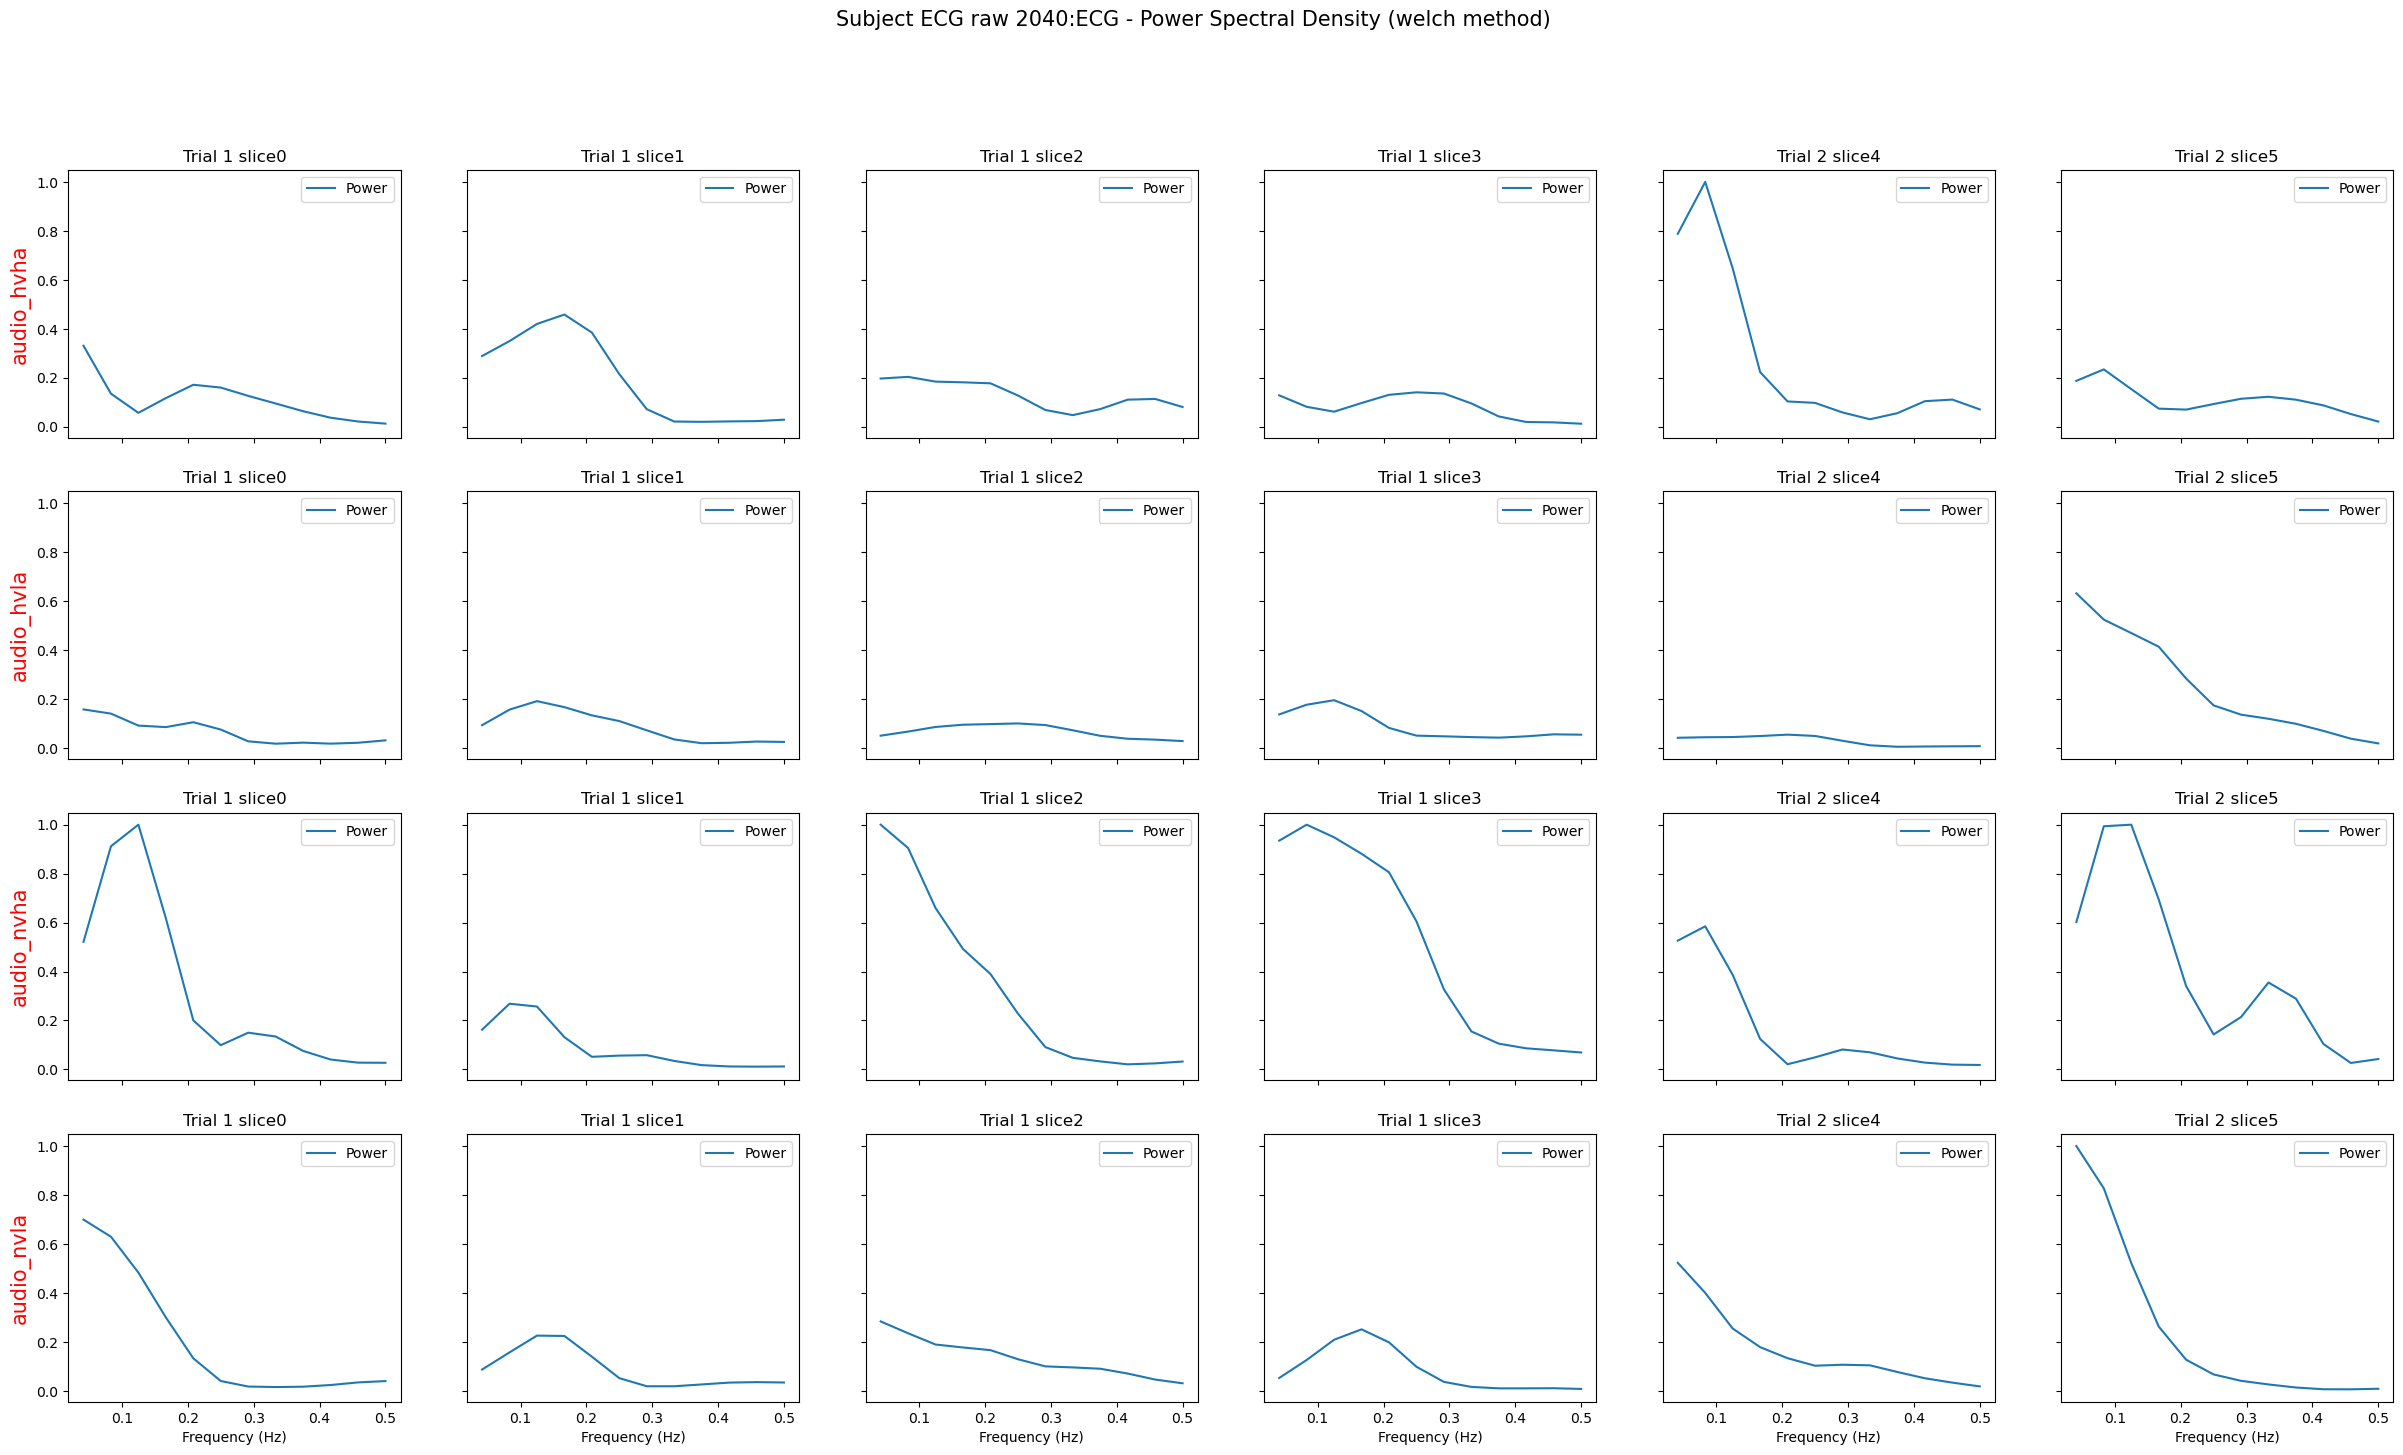

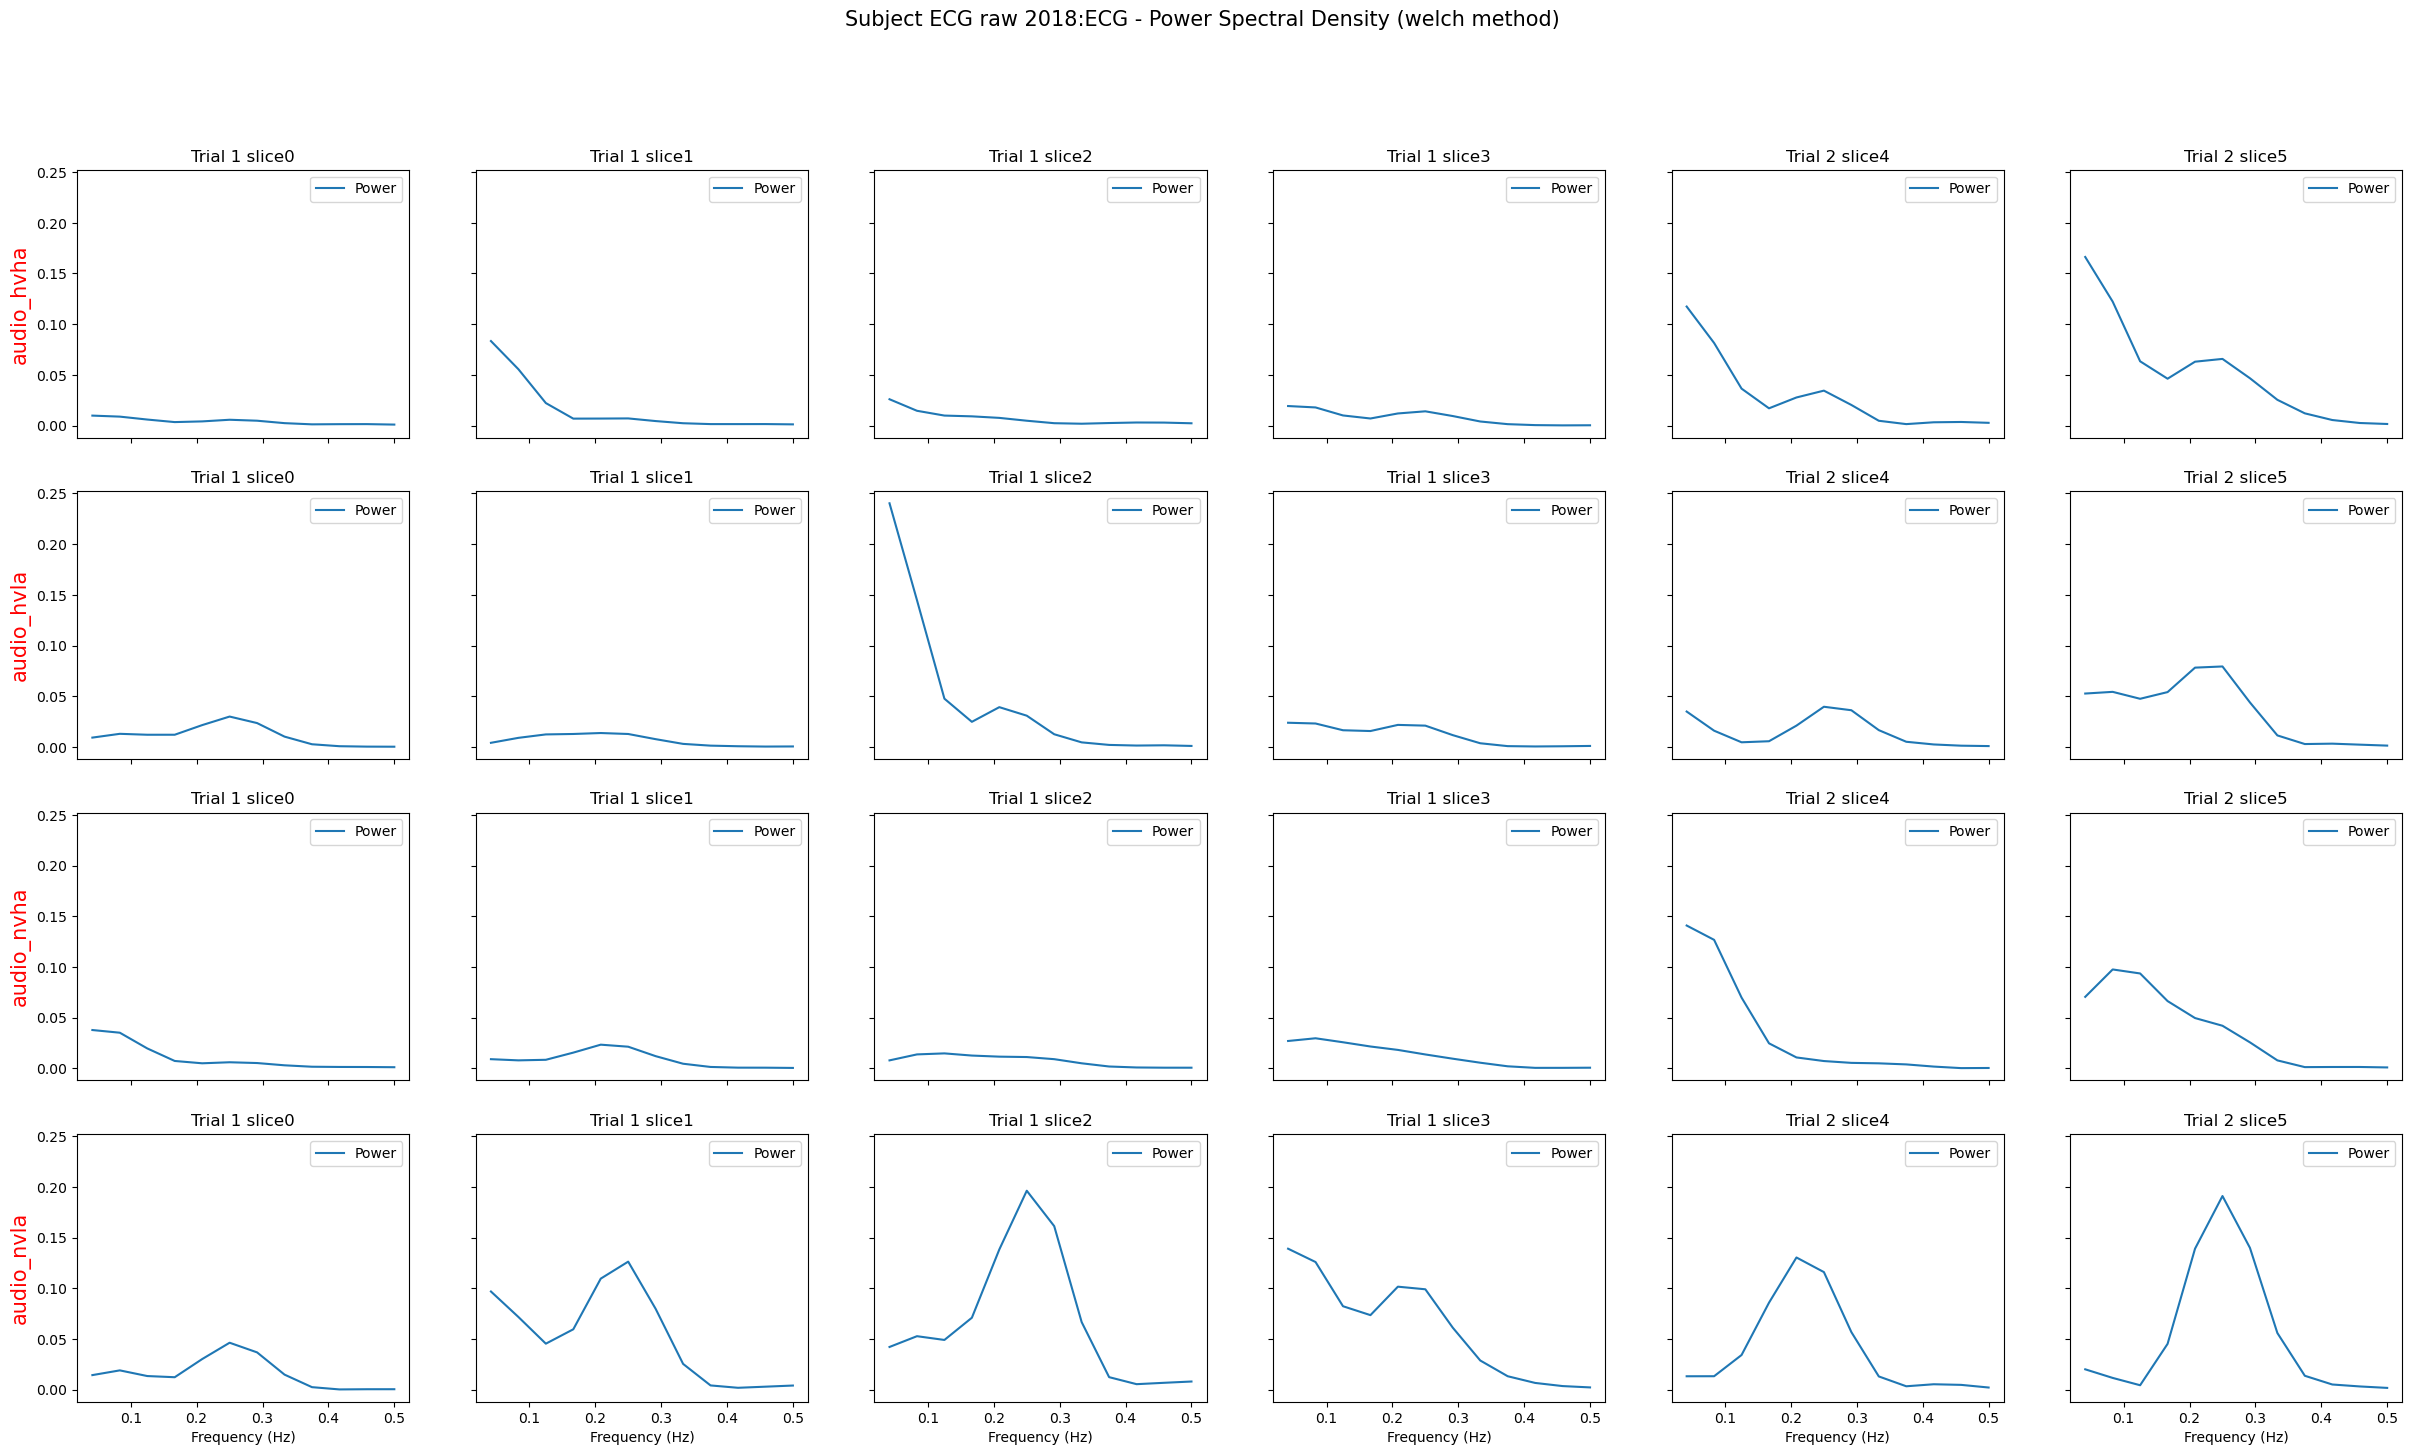

In [5]:
#nk.signal_psd(data, sampling_rate=srate, method="welch", show=True) #, min_frequency=0.12, max_frequency=0.4)
num_slices = 6
for subj in subject_data_list:
    fig, axes = plt.subplots(
        nrows=len(AUDIO_BLOCKS),
        ncols=num_slices,
        figsize=(num_slices * 5, len(AUDIO_BLOCKS) * 4),
        sharey=True,
        sharex=True,
    )
    subject_data = subj_to_data[subj]
    block_to_data = _get_block_raw_data_by_marker(subject_data, AUDIO_BLOCKS, marker, 24)
    idx = 0
    for block, bdata in block_to_data.items():
        for i in range(num_slices):
            df = nk.signal_psd(bdata[i], sampling_rate=srate, method="welch", show=False, min_frequency=0, max_frequency=0.5)

            t = int(i/4)+1
            ax = df.plot(x="Frequency", y="Power", title=f"Trial {t} slice{i}", ax=axes.flat[idx])
            ax.set(xlabel="Frequency (Hz)", ylabel="Spectrum")
            # axes.flat[idx].set_xlim(0, 1)
            idx += 1
            if i == 0:
                ax.set_ylabel(
                    block,
                    fontsize=15,
                    color="red",
                )            

    fig.suptitle(f"Subject ECG raw {subj}:{marker} - Power Spectral Density (welch method)", fontsize=15)

## Plot HRV PSD

In [36]:
# Find peaks
def _hrv_get_rri(peaks=None, sampling_rate=1000):
    # Compute R-R intervals (also referred to as NN) in milliseconds
    rri = np.diff(peaks) / sampling_rate * 1000
    # Impute intervals with median in case of missing values to calculate timestamps
    imputed_intervals = np.where(np.isnan(rri), np.nanmedian(rri, axis=0), rri)
    # Compute the timestamps of the intervals in seconds
    intervals_time = np.nancumsum(imputed_intervals / 1000)
    return rri, intervals_time


def _get_ecg_hrv_psd(block_data, srate: int, min_frequency=0, max_frequency=0.5):
    psd_data = []
    num_trials = block_data.shape[0]
    # loop through all trials: time -> frequency
    for t in range(num_trials):
        peaks, info = nk.ecg_peaks(bdata[t], sampling_rate=srate)
        rri, rri_time = _hrv_get_rri(peaks["ECG_R_Peaks"].values, sampling_rate=srate)
        # Process R-R intervals (interpolated at 100 Hz by default)
        rri, rri_time, sampling_rate = nk.intervals_process(
            rri,
            intervals_time=rri_time,
            interpolate=True,
            interpolation_rate=None,
        )

        df = nk.signal_psd(
            rri,
            sampling_rate=srate,
            method="welch",
            show=False,
            min_frequency=min_frequency,
            max_frequency=max_frequency,
            t=rri_time,
        )
        psd_data.append(df.Power.values)

    return np.stack(psd_data, axis=0)

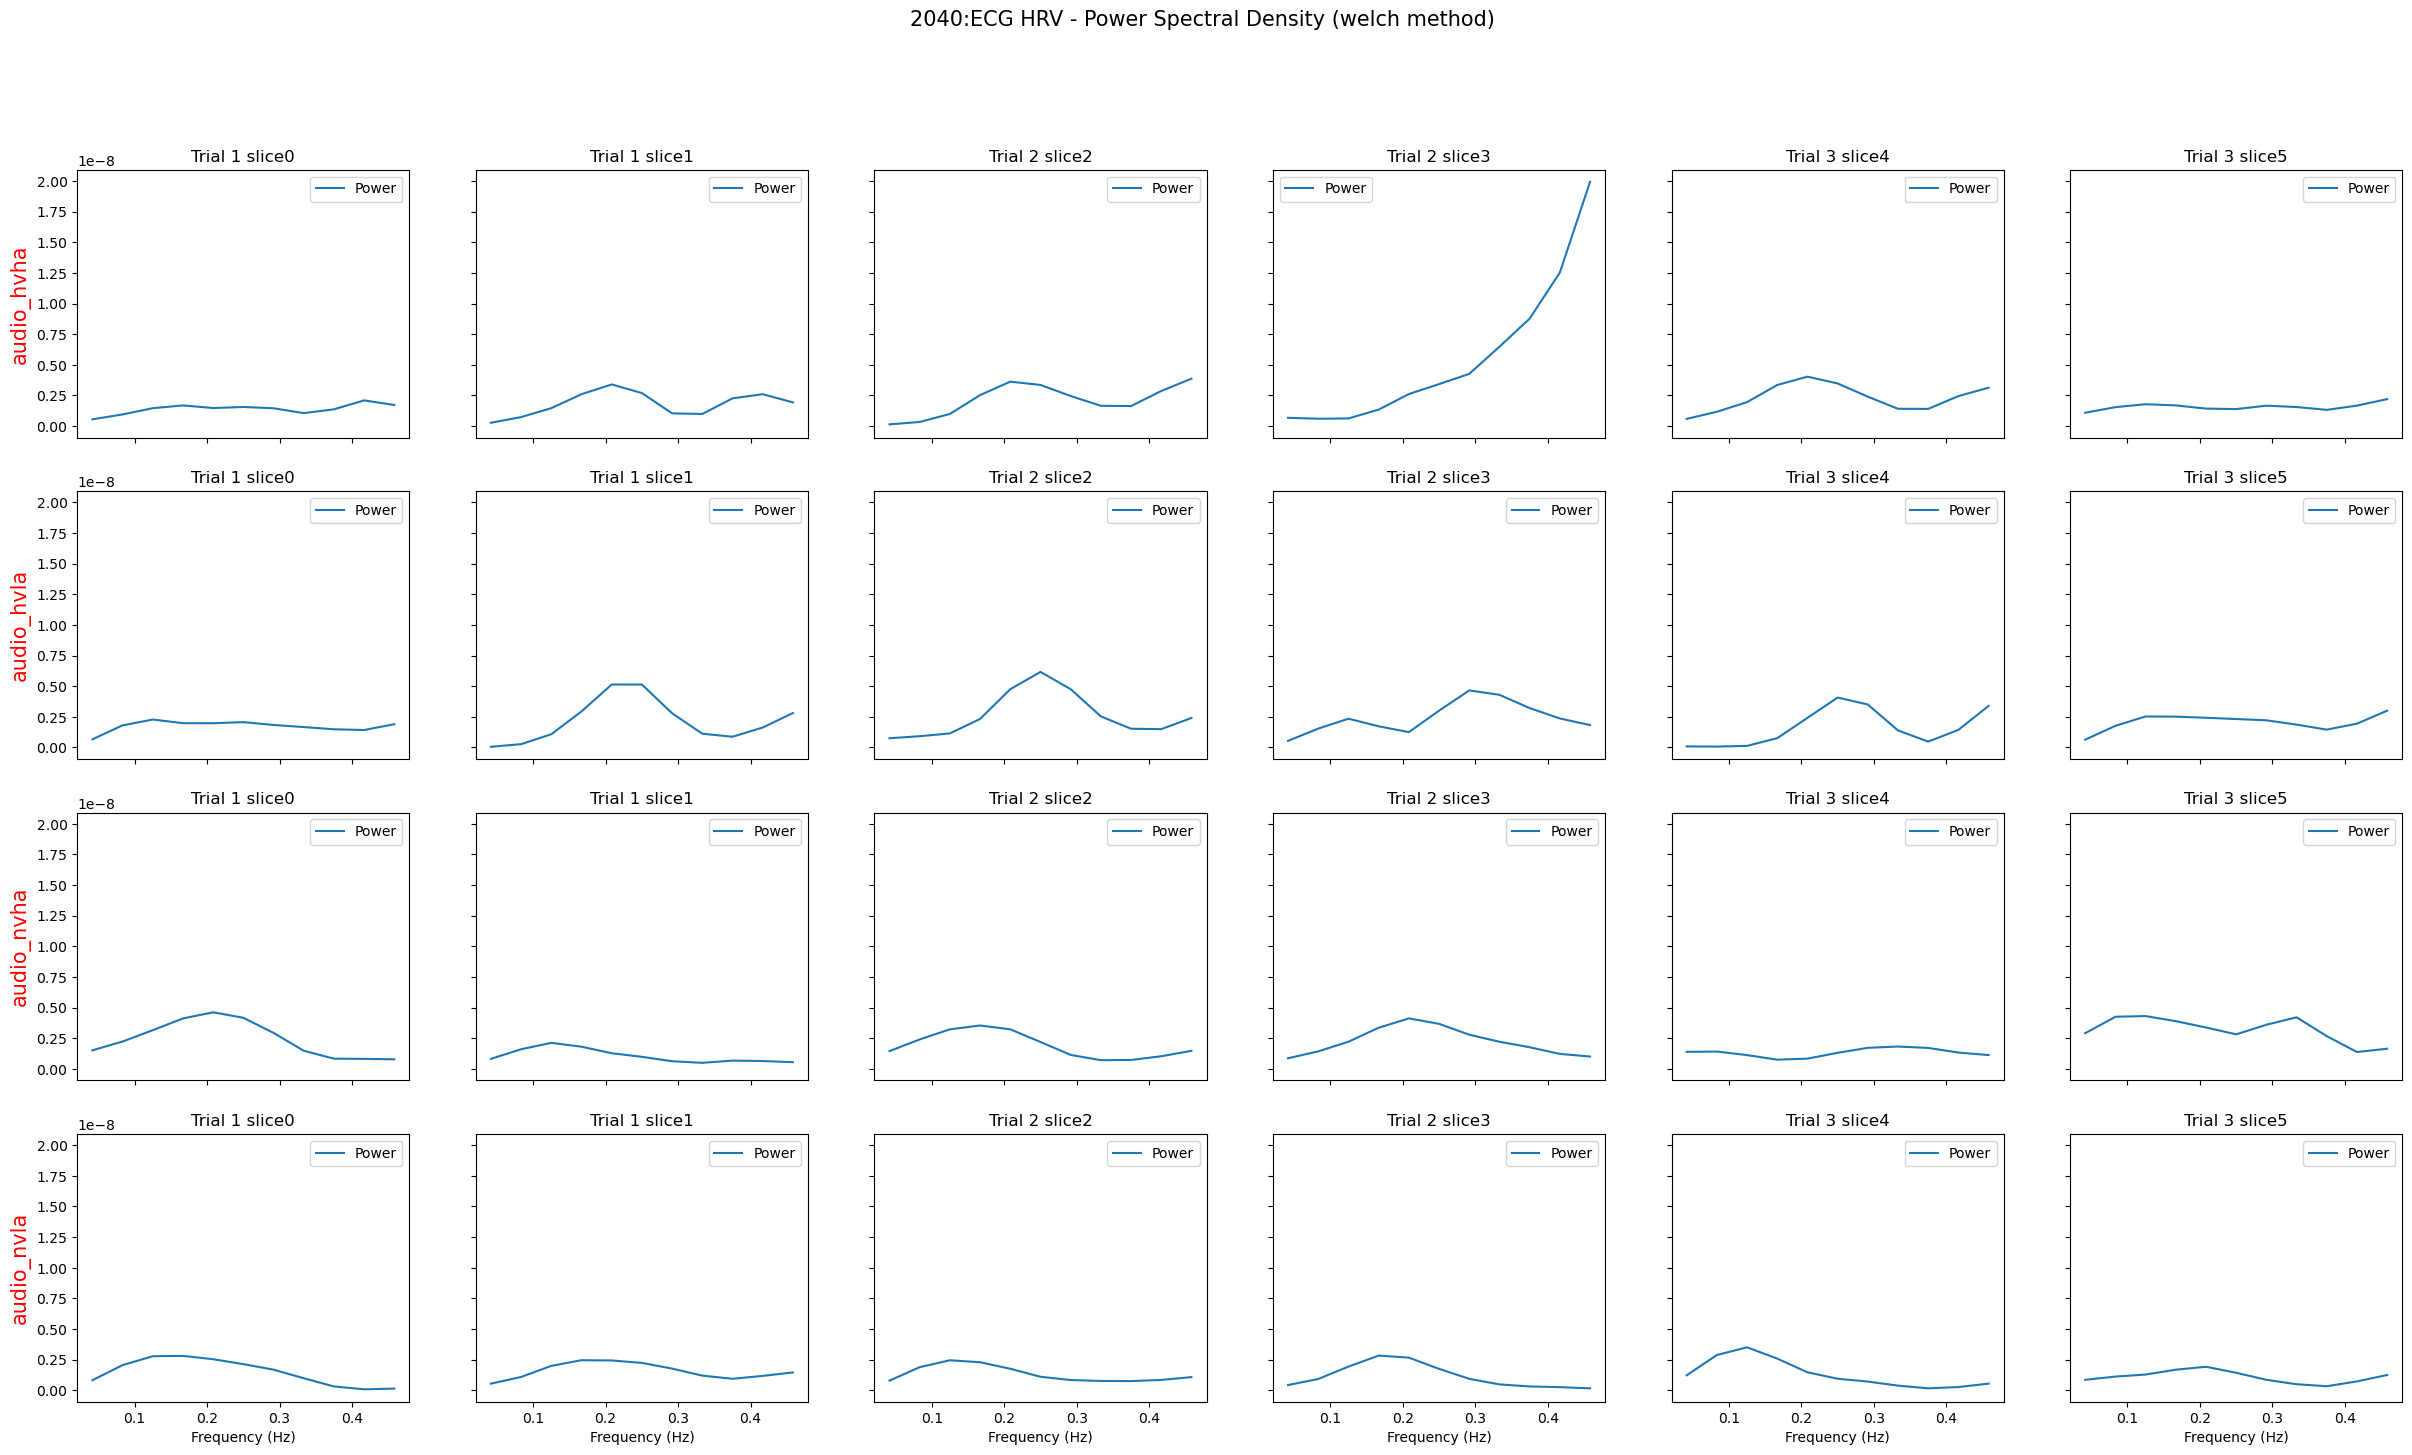

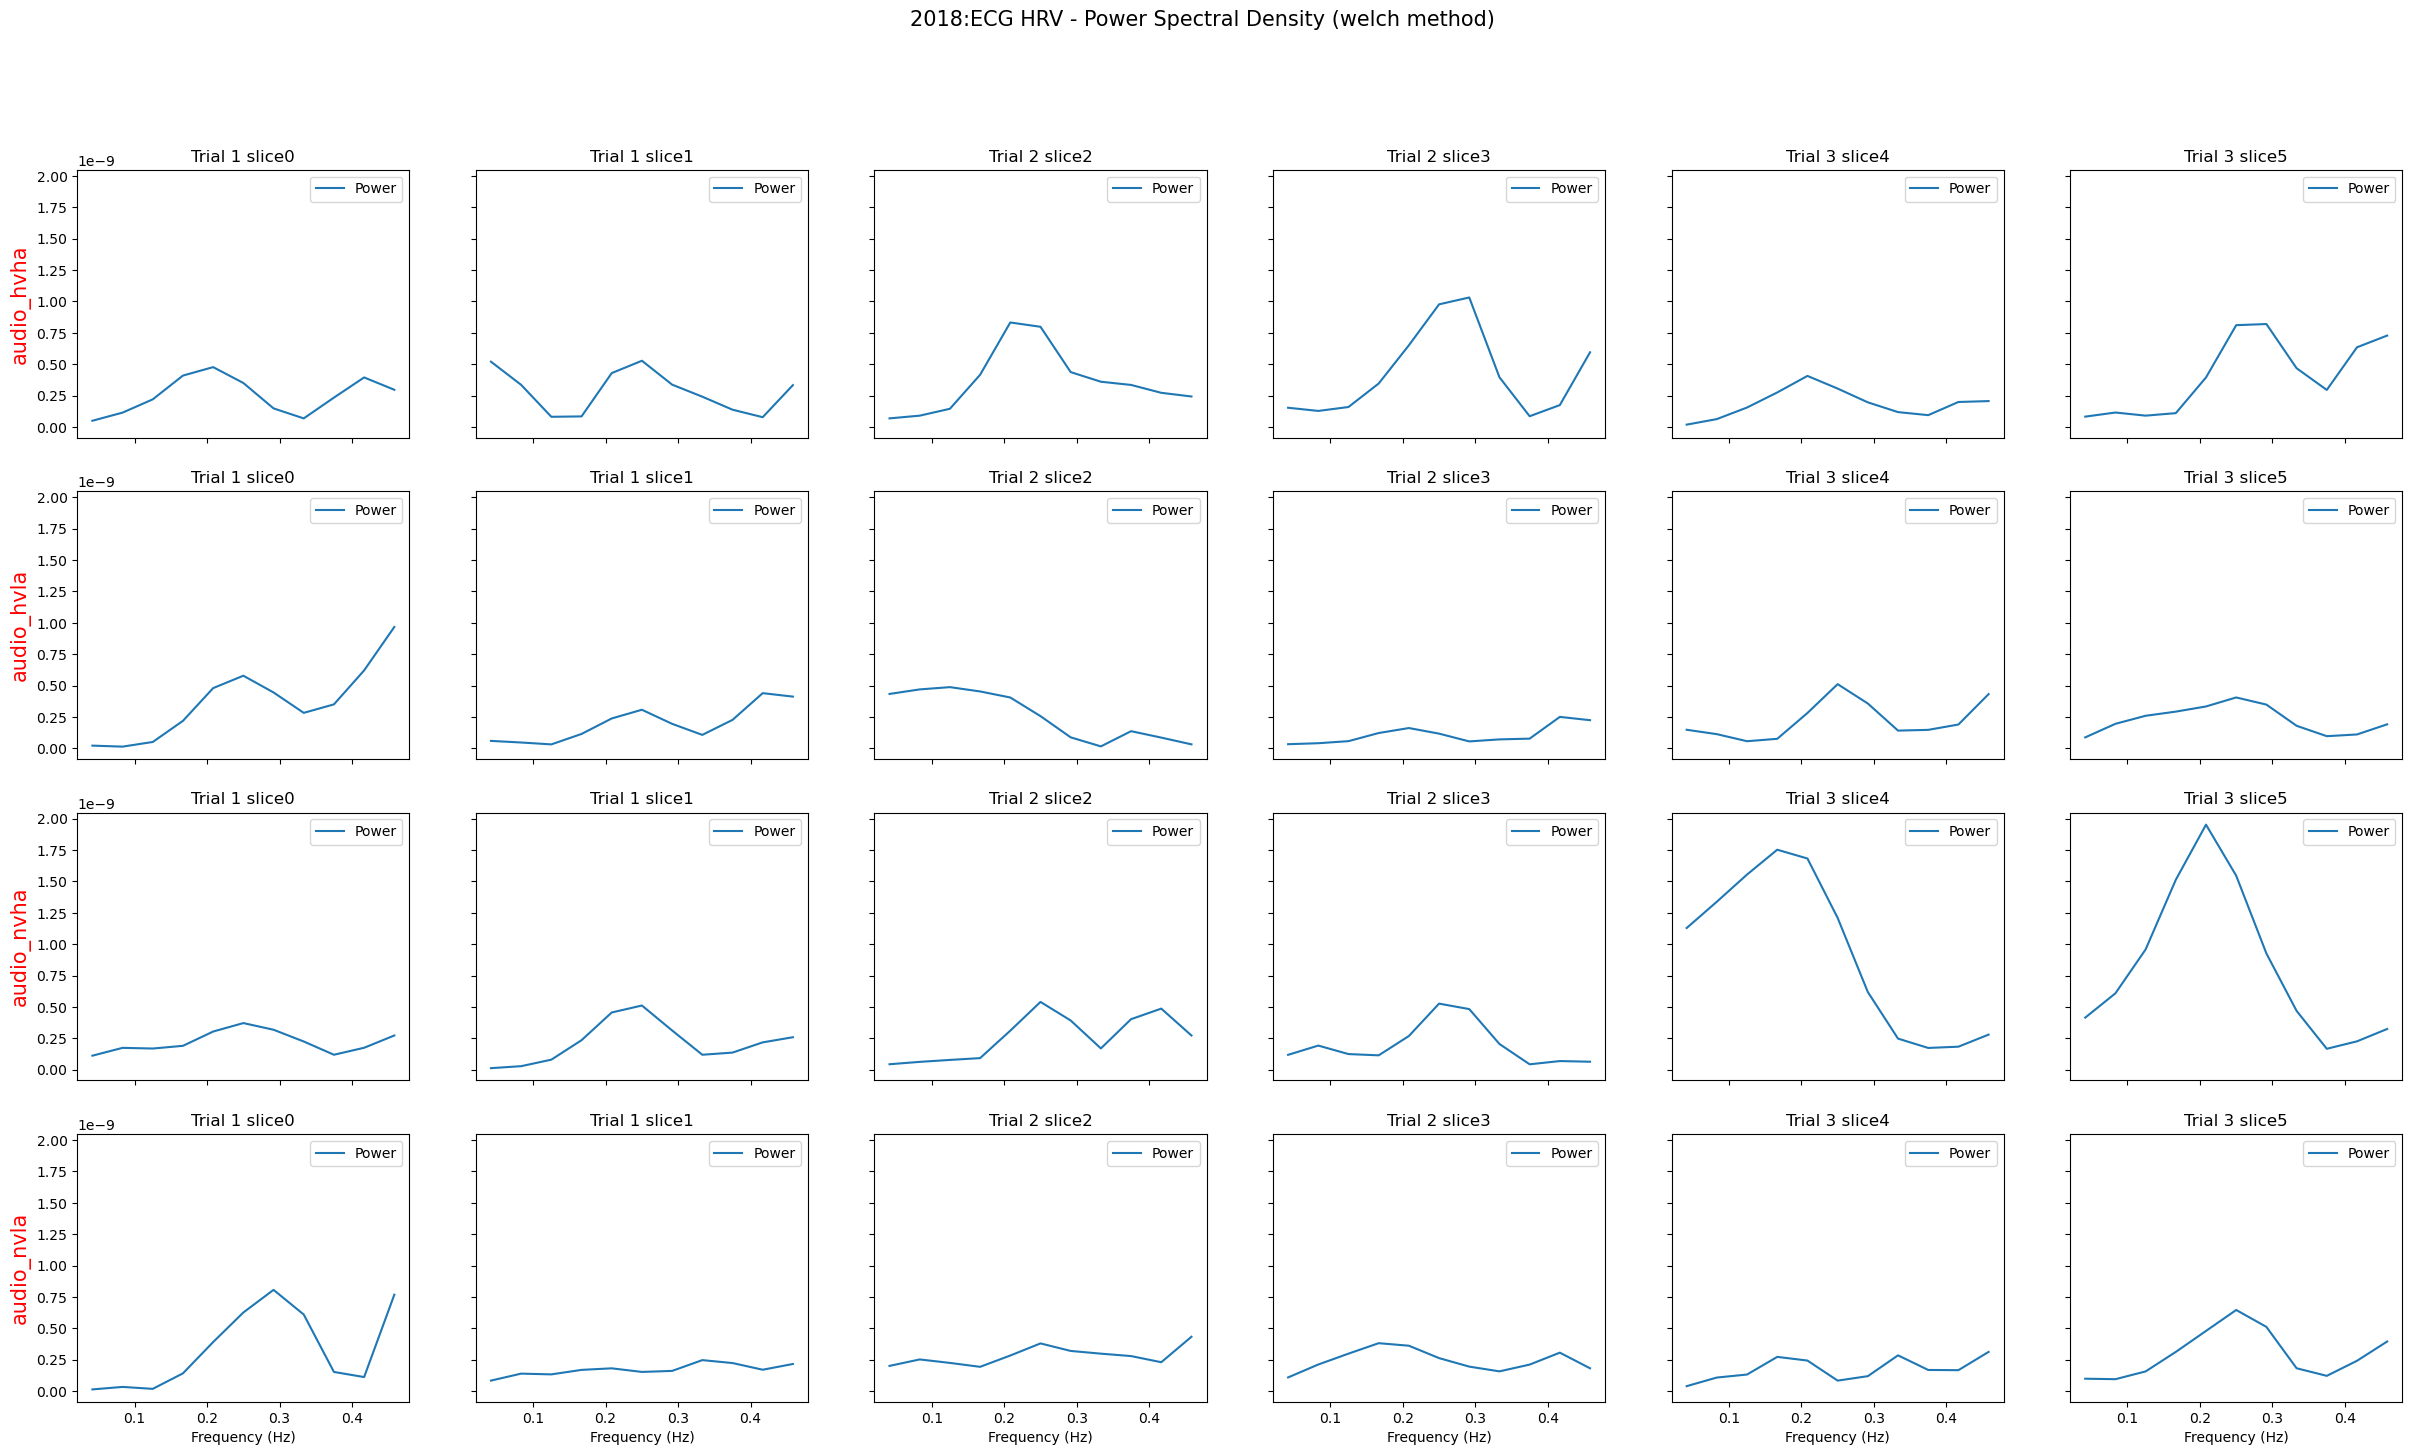

In [8]:
num_slices = 6
for subj in subject_data_list:
    fig, axes = plt.subplots(
        nrows=len(AUDIO_BLOCKS),
        ncols=num_slices,
        figsize=(num_slices * 5, len(AUDIO_BLOCKS) * 4),
        sharey=True,
        sharex=True,
    )
    subject_data = subj_to_data[subj]
    block_to_data = _get_block_raw_data_by_marker(subject_data, AUDIO_BLOCKS, marker, 24)
    idx = 0
    for block, bdata in block_to_data.items():
        for i in range(num_slices):
            peaks, info = nk.ecg_peaks(bdata[i], sampling_rate=srate)
            rri, rri_time = _hrv_get_rri(peaks['ECG_R_Peaks'].values, sampling_rate=srate)
            # Process R-R intervals (interpolated at 100 Hz by default)
            rri, rri_time, sampling_rate = nk.intervals_process(
                rri, intervals_time=rri_time, interpolate=True, interpolation_rate=None,
            )            
            df = nk.signal_psd(rri, sampling_rate=srate, method="welch", show=False, min_frequency=0, max_frequency=0.5, t=rri_time)
            
            t = int(i/2)+1 #i+1 #
            ax = df.plot(x="Frequency", y="Power", title=f"Trial {t} slice{i}", ax=axes.flat[idx])
            ax.set(xlabel="Frequency (Hz)", ylabel="Spectrum")
            
            idx += 1
            if i == 0:
                ax.set_ylabel(
                    block,
                    fontsize=15,
                    color="red",
                )            
        
    fig.suptitle(f"{subj}:{marker} HRV - Power Spectral Density (welch method)", fontsize=15)

## Extract features

In [9]:
sec_per_slice = 24
max_freq = 0.5

ecg_raw, subject_lists = [], []
all_features = []
for i, d in enumerate(os.listdir(data_dir)):
    dir_name = data_dir + d
    if not os.path.isdir(dir_name):
        continue

    data = load_data_from_dir(dir_name)
    block_to_data = _get_block_raw_data_by_marker(data, AUDIO_BLOCKS, marker, sec_per_slice)
    ecg_raw.append(block_to_data)
    subject_lists.append(d)

    # features = []
    # for b in AUDIO_BLOCKS:
    #     block_data = block_to_data[b]
    #     psd_data = _get_ecg_hrv_psd(block_data, srate, 0, max_freq)
    #     features = np.vstack((psd_data, features)) if len(features) > 0 else psd_data
    # all_features.append(features)
    # print(f'Finishing {d} with features {features[0].shape}')

Loading ../CleandDataV2/2040 data...
Loading ../CleandDataV2/2013 data...
Loading ../CleandDataV2/2022 data...
Loading ../CleandDataV2/2025 data...
Loading ../CleandDataV2/2046 data...
Loading ../CleandDataV2/2041 data...
Loading ../CleandDataV2/2024 data...
Loading ../CleandDataV2/2012 data...
Loading ../CleandDataV2/2037 data...
Loading ../CleandDataV2/2001 data...
Loading ../CleandDataV2/2039 data...
Loading ../CleandDataV2/2006 data...
Loading ../CleandDataV2/2038 data...
Loading ../CleandDataV2/2007 data...
Loading ../CleandDataV2/2000 data...
Loading ../CleandDataV2/2009 data...
Loading ../CleandDataV2/2036 data...
Loading ../CleandDataV2/2031 data...
Loading ../CleandDataV2/2017 data...
Loading ../CleandDataV2/2028 data...
Loading ../CleandDataV2/2010 data...
Loading ../CleandDataV2/2026 data...
Loading ../CleandDataV2/2019 data...
Loading ../CleandDataV2/2021 data...
Loading ../CleandDataV2/2044 data...
Loading ../CleandDataV2/2043 data...
Loading ../CleandDataV2/2020 data...
L

In [10]:
with open(f'data/ecg_raw.pkl', 'wb') as handle:
    d = {'ecg_raw': ecg_raw}
    pickle.dump(d, handle, protocol=pickle.HIGHEST_PROTOCOL)

## NK lib exploeration

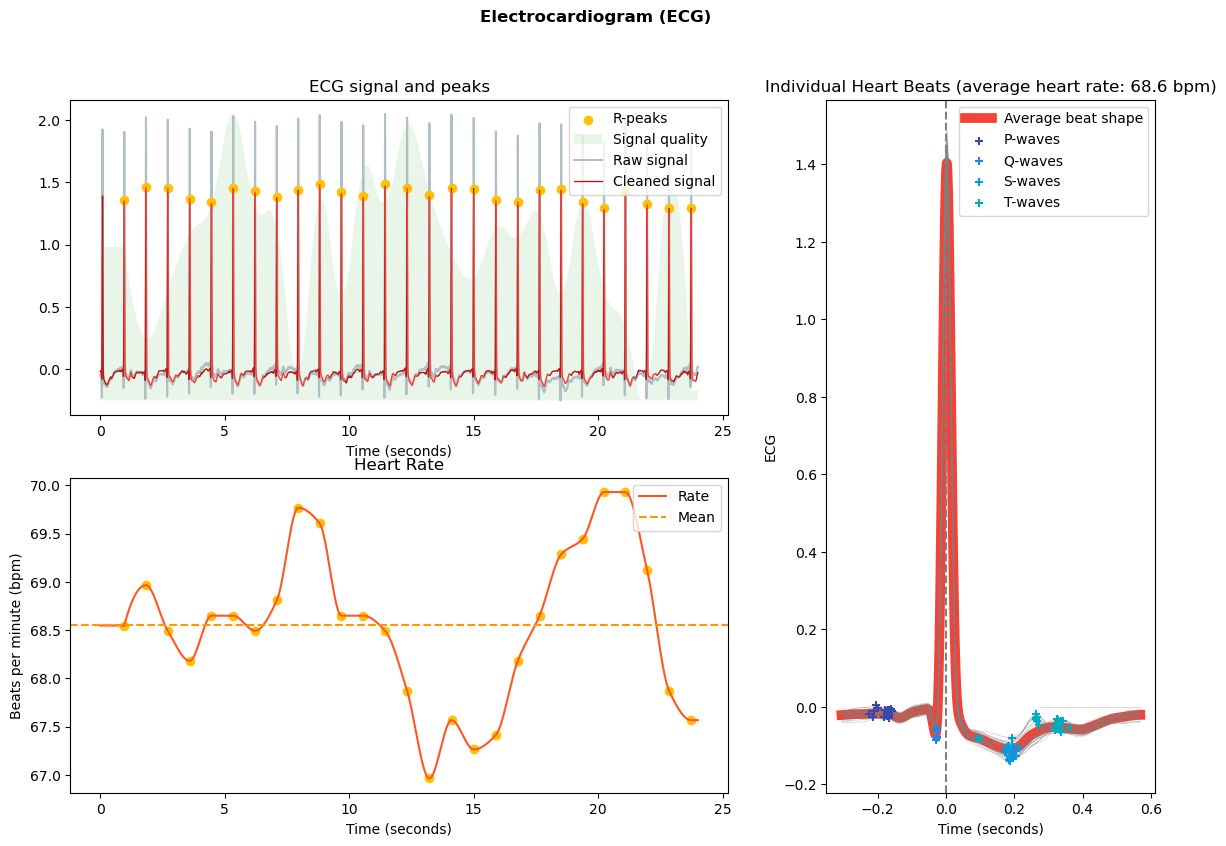

In [19]:
data = block_to_data['audio_hvha'][0]
ecg_signals, info = nk.ecg_process(data, sampling_rate=srate)

nk.ecg_plot(ecg_signals, info)
fig = plt.gcf()
fig.set_size_inches(14, 9, forward=True)

/Users/ccnlab/miniconda3/envs/MM/lib/python3.8/site-packages/neurokit2/hrv/hrv_nonlinear.py:474: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


Index(['HRV_MeanNN', 'HRV_SDNN', 'HRV_SDANN1', 'HRV_SDNNI1', 'HRV_SDANN2',
       'HRV_SDNNI2', 'HRV_SDANN5', 'HRV_SDNNI5', 'HRV_RMSSD', 'HRV_SDSD',
       'HRV_CVNN', 'HRV_CVSD', 'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN',
       'HRV_IQRNN', 'HRV_SDRMSSD', 'HRV_Prc20NN', 'HRV_Prc80NN', 'HRV_pNN50',
       'HRV_pNN20', 'HRV_MinNN', 'HRV_MaxNN', 'HRV_HTI', 'HRV_TINN', 'HRV_ULF',
       'HRV_VLF', 'HRV_LF', 'HRV_HF', 'HRV_VHF', 'HRV_TP', 'HRV_LFHF',
       'HRV_LFn', 'HRV_HFn', 'HRV_LnHF', 'HRV_SD1', 'HRV_SD2', 'HRV_SD1SD2',
       'HRV_S', 'HRV_CSI', 'HRV_CVI', 'HRV_CSI_Modified', 'HRV_PIP',
       'HRV_IALS', 'HRV_PSS', 'HRV_PAS', 'HRV_GI', 'HRV_SI', 'HRV_AI',
       'HRV_PI', 'HRV_C1d', 'HRV_C1a', 'HRV_SD1d', 'HRV_SD1a', 'HRV_C2d',
       'HRV_C2a', 'HRV_SD2d', 'HRV_SD2a', 'HRV_Cd', 'HRV_Ca', 'HRV_SDNNd',
       'HRV_SDNNa', 'HRV_DFA_alpha1', 'HRV_MFDFA_alpha1_Width',
       'HRV_MFDFA_alpha1_Peak', 'HRV_MFDFA_alpha1_Mean',
       'HRV_MFDFA_alpha1_Max', 'HRV_MFDFA_alpha1_Delta',
     

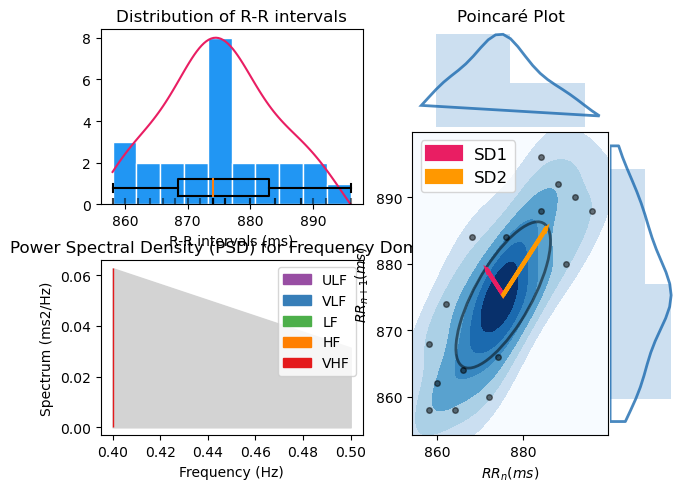

In [73]:
# Extract clean EDA and SCR features
data = block_to_data['audio_hvha'][0]
# Clean signal and Find peaks
ecg_cleaned = nk.ecg_clean(data, sampling_rate=srate)
peaks, info = nk.ecg_peaks(ecg_cleaned, sampling_rate=srate, correct_artifacts=True)
# Compute HRV indices
hrv_indices = nk.hrv(peaks, sampling_rate=srate, show=True)
hrv_indices.keys()

In [119]:
def _get_hrv_feature(ecg_raw):
    block_hrv_f = []
    for b in AUDIO_BLOCKS:
        data = ecg_raw[b]
        for t in range(len(data)):
            cleaned = nk.ecg_clean(data[t], sampling_rate=srate, method="neurokit")
            peaks, info = nk.ecg_peaks(cleaned, sampling_rate=srate, correct_artifacts=True)
            hrv_feature = nk.hrv(peaks, sampling_rate=srate, show=False)
            block_hrv_f.append(hrv_feature)
    return block_hrv_f

def _get_rr_feature(ecg_raw):
    block_hrv_f = []
    for b in AUDIO_BLOCKS:
        data = ecg_raw[b]
        for t in range(len(data)):
            cleaned = nk.ecg_clean(data[t], sampling_rate=srate, method="neurokit")
            peaks, info = nk.ecg_peaks(cleaned, sampling_rate=srate, correct_artifacts=True)
            block_hrv_f.append(peaks['ECG_R_Peaks'].values)
    return block_hrv_f


#all_hrv_features = [ _get_hrv_feature(data) for data in ecg_raw]
all_rr_features = [ _get_rr_feature(data) for data in ecg_raw]

In [122]:
#np.array(all_rr_features).shape
with open(f'data/ecg_rr_peaks.pkl', 'wb') as handle:
    d = {'ecg_rr_peaks': np.array(all_rr_features)}
    pickle.dump(d, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
# Read labels pkl file with slicing behavioral
with open("./data/behavioral_labels.pkl", "rb") as fp:
    behavioral_labels = pickle.load(fp)

sliced_valence_labels, sliced_arousal_labels, _ = (
    behavioral_labels["valence_labels"],
    behavioral_labels["arousal_labels"],
    behavioral_labels["attention_labels"],
)

# Load labels without slice
num_slice_per_trial = 5
valence_labels, arousal_labels = [], []
for si in range(len(sliced_valence_labels)):
    vls, als = sliced_valence_labels[si], sliced_arousal_labels[si]
    filter_indexes = np.arange(0, len(vls), num_slice_per_trial)
    valence_labels.append(np.array(vls)[filter_indexes])
    arousal_labels.append(np.array(als)[filter_indexes])

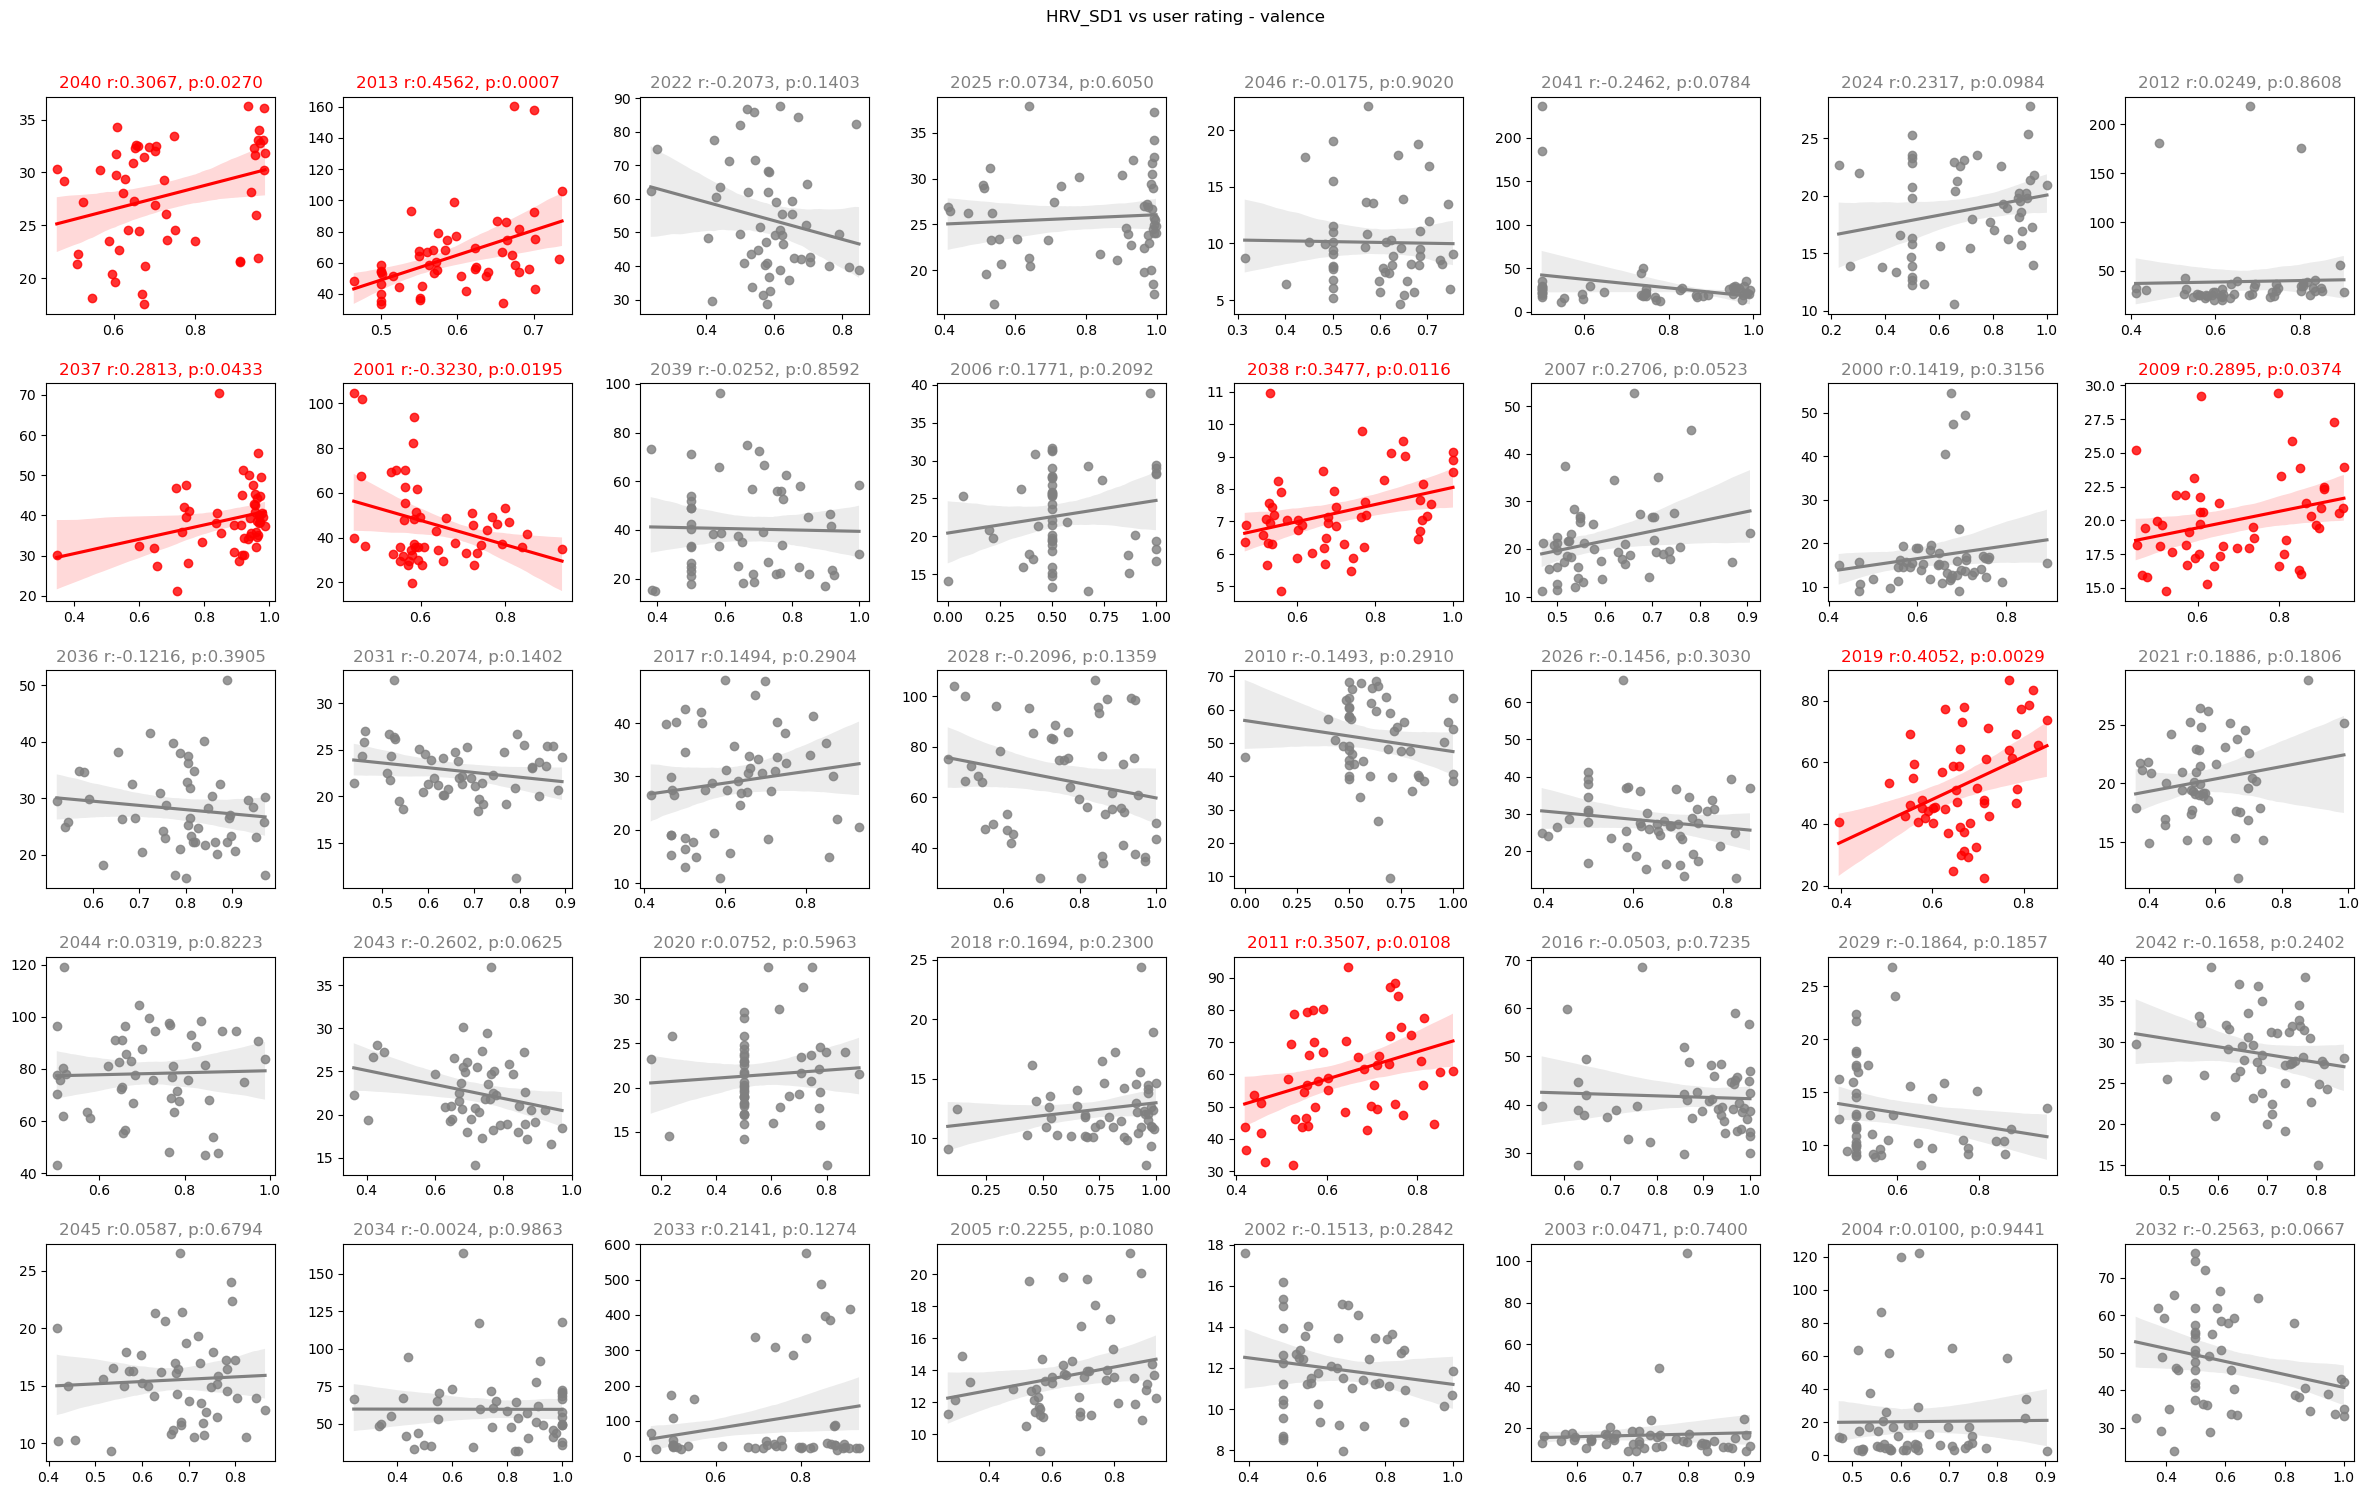

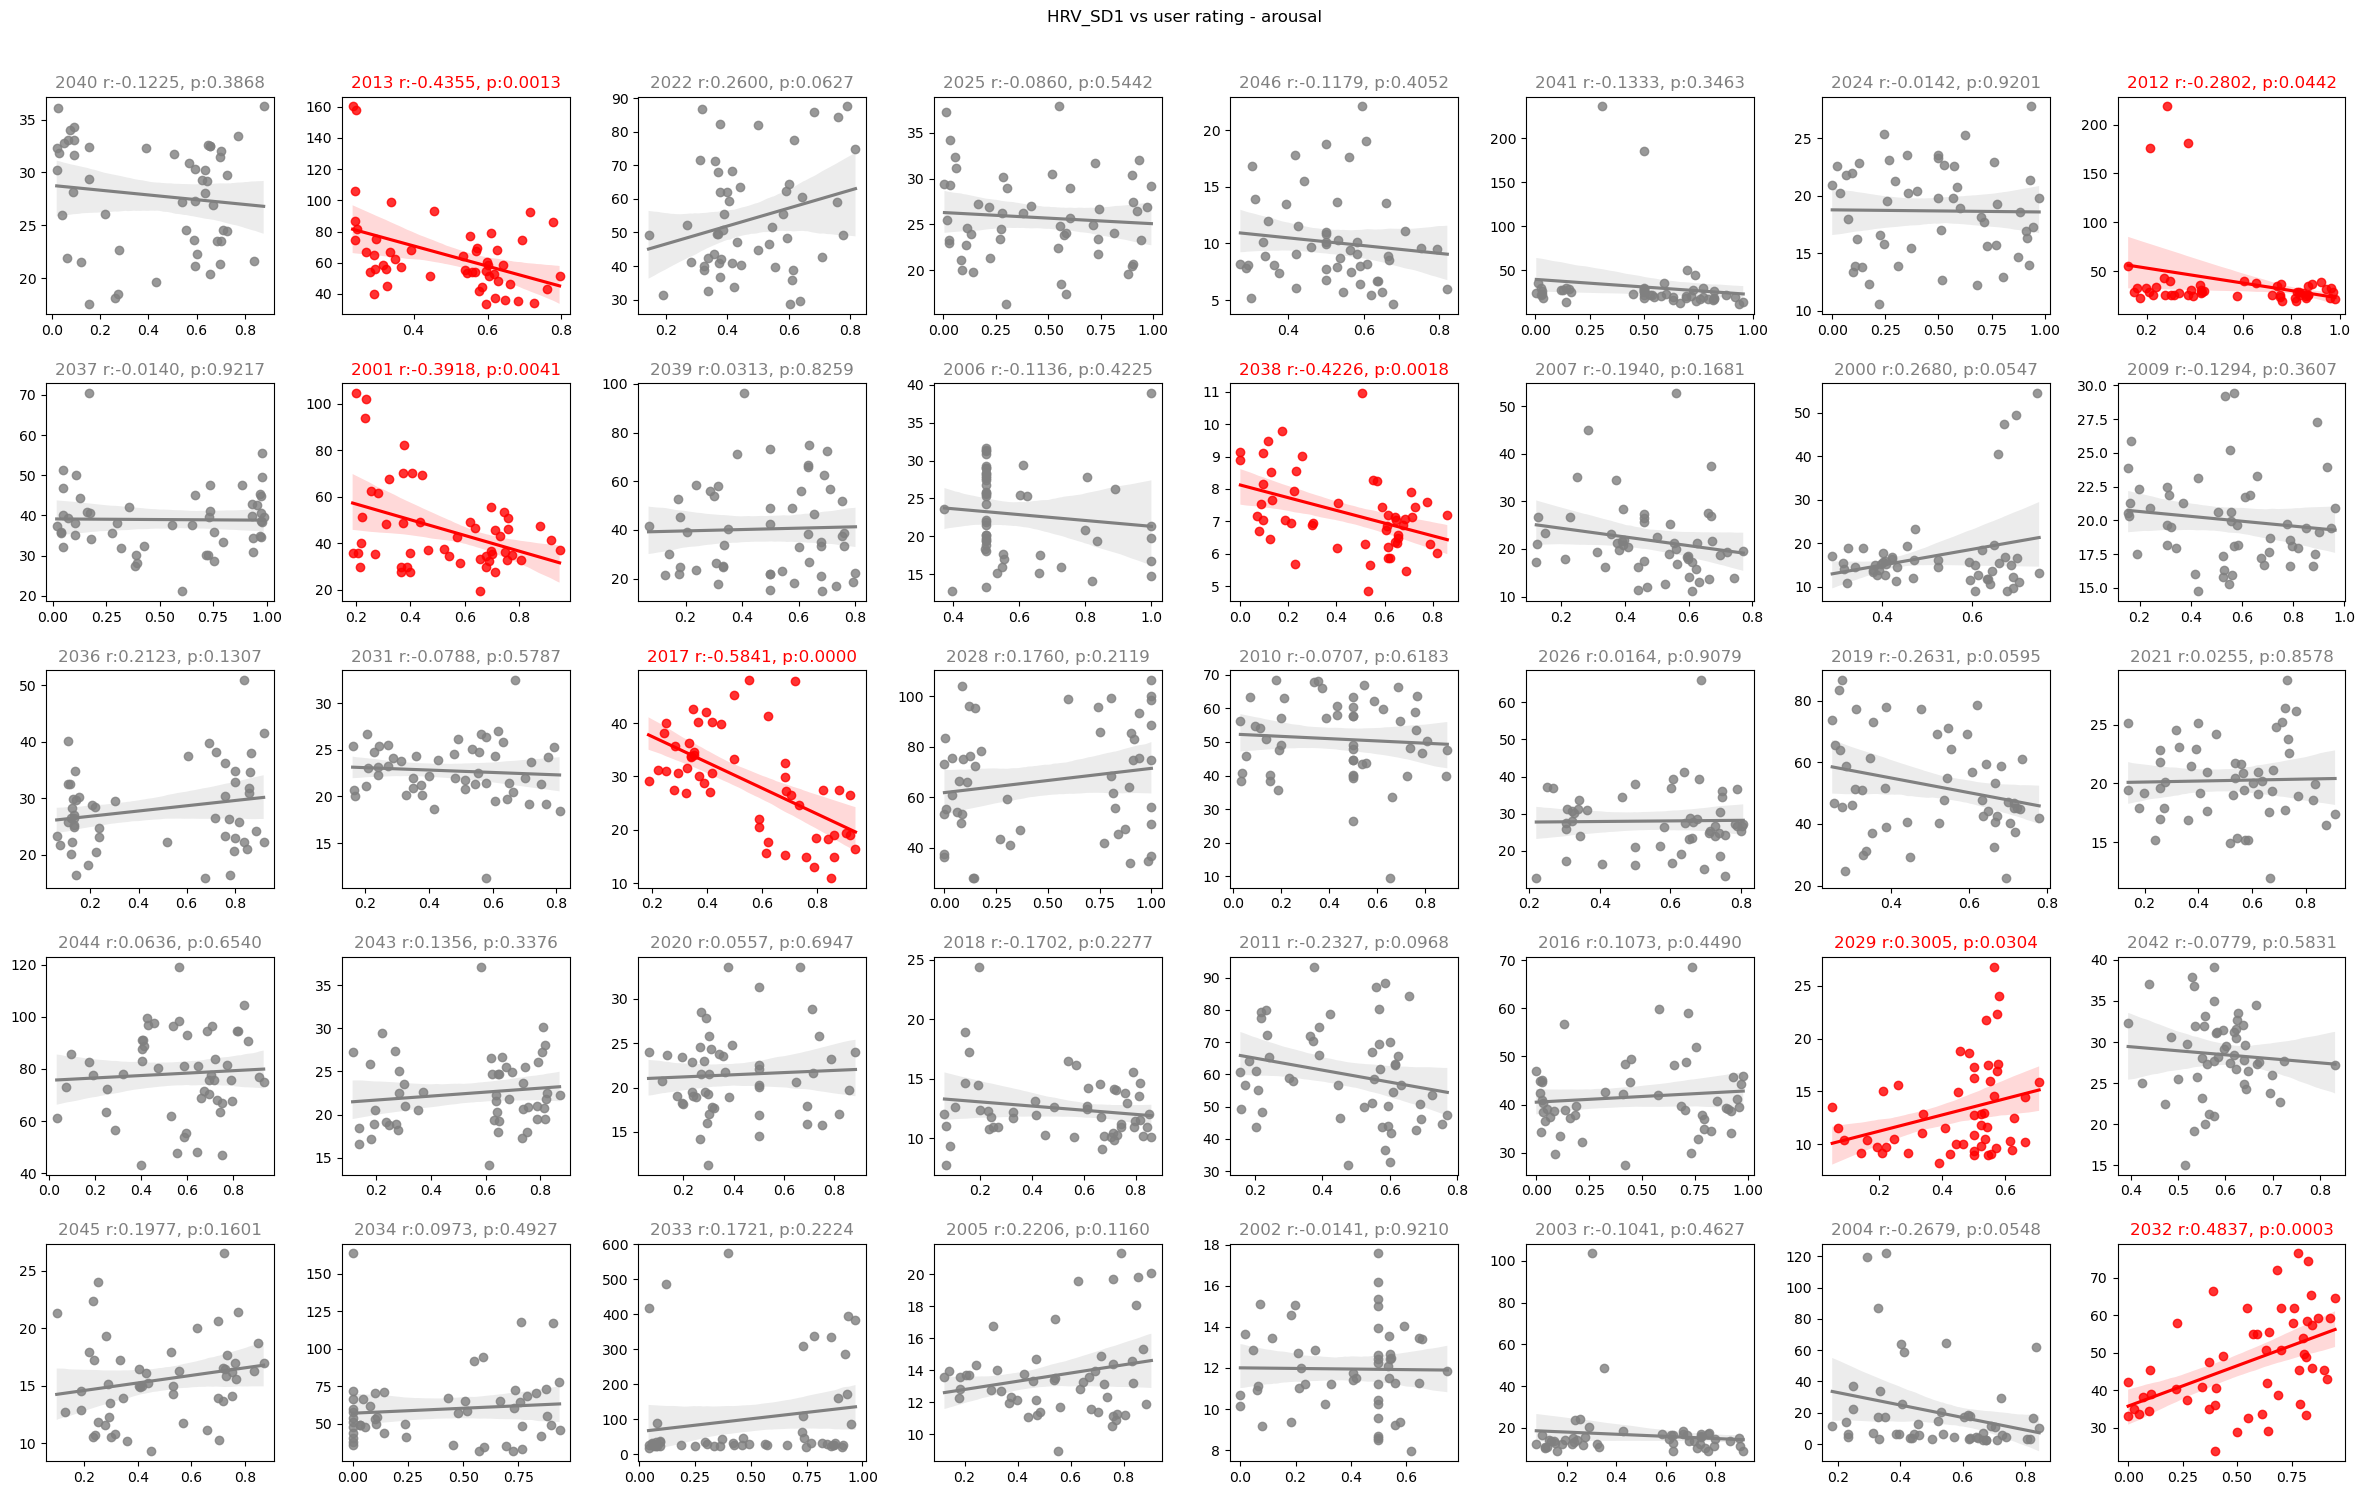

In [76]:
from scipy import stats

def _extact_hrv_feature_by_name(block_hrv_features, feature_key='HRV_SDNN'):
    return [hrv_f[feature_key].values[0] for hrv_f in block_hrv_features]

feature_key = 'HRV_SD1' #HRV_VHF, HRV_HFn
for l, labels in {'valence': valence_labels, 'arousal': arousal_labels}.items():
    n_row, n_col = (5, 8)
    fig, axes = plt.subplots(
        nrows=n_row,
        sharey=False,
        ncols=n_col,
        figsize=(n_col * 3, n_row * 3),
    )

    for i, ax in enumerate(axes.flat):
        s = str(subject_lists[i])

        block_hrv_std = _extact_hrv_feature_by_name(all_hrv_features[i], feature_key)
        r_v, p_v = stats.pearsonr(labels[i], block_hrv_std)
       
        color = 'red' if p_v < .05 else 'grey' 
        result = pd.DataFrame({'user rating': labels[i], 'hrv_std': block_hrv_std})
        g1 = sns.regplot(data=result, x="user rating", y="hrv_std", ax=ax, color=color)
        g1.set(xlabel=None, ylabel=None)
        g1.set_title(f'{s} r:{r_v:2.4f}, p:{p_v:2.4f}', fontsize=12, color=color)
        

    fig.suptitle(
        f"{feature_key} vs user rating - {l}",
        y=1
    )
    fig.tight_layout(pad=1.8)

In [70]:
time_features = []
f_names = [
    "HRV_MeanNN",
    "HRV_SDNN",
    "HRV_RMSSD",
    "HRV_MinNN",
    "HRV_MaxNN",
    "HRV_MedianNN",
    "HRV_MadNN",
    "HRV_MCVNN",
    "HRV_IQRNN",
    'HRV_Prc20NN',
    'HRV_Prc80NN',
    'HRV_SDRMSSD',
]
for sub_data in all_hrv_features:
    block_features = [data[f_names].values[0] for data in sub_data]
    time_features.append(block_features)
time_features = np.array(time_features)
# with open(f'data/ecg_time_features.pkl', 'wb') as handle:
#     d = {'ecg_time_features': time_features}
#     pickle.dump(d, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [107]:
# Import function for Morlet Wavelets
from neurodsp.plts import plot_time_series, plot_timefrequency
from neurodsp.utils import create_times
from neurodsp.timefrequency.wavelets import compute_wavelet_transform

def _get_hrv_tf_with_wavelet(ecg_raw, n_cycles=0.5):
    # Settings for the wavelet transform algorithm
    freqs = np.linspace(0.15, 0.5, 3)    
    block_hrv_tf = []
    for b in AUDIO_BLOCKS:
        for sig in ecg_raw[b]:
            cleaned = nk.ecg_clean(sig, sampling_rate=srate, method="neurokit")
            peaks, _ = nk.ecg_peaks(cleaned, sampling_rate=srate, correct_artifacts=True)
            rri, rri_time = _hrv_get_rri(peaks['ECG_R_Peaks'].values, sampling_rate=srate)
            # Process R-R intervals (interpolated at 100 Hz by default)
            rri, rri_time, _ = nk.intervals_process(
                rri, intervals_time=rri_time, interpolate=True, interpolation_rate=None,
            )
            # Compute wavelet transform using compute Morlet wavelet transform algorithm
            mwt = compute_wavelet_transform(rri, fs=srate, n_cycles=n_cycles, freqs=freqs)
            block_hrv_tf.append(abs(mwt).ravel())
    return np.array(block_hrv_tf)

all_mwt = [_get_hrv_tf_with_wavelet(subj_data) for subj_data in ecg_raw]
np.array(all_mwt).shape

(41, 52, 35997)

In [108]:
with open(f'data/ecg_time_freq_wavelet.pkl', 'wb') as handle:
    d = {'ecg_time_freq_wavelet': np.array(all_mwt)}
    pickle.dump(d, handle, protocol=pickle.HIGHEST_PROTOCOL)

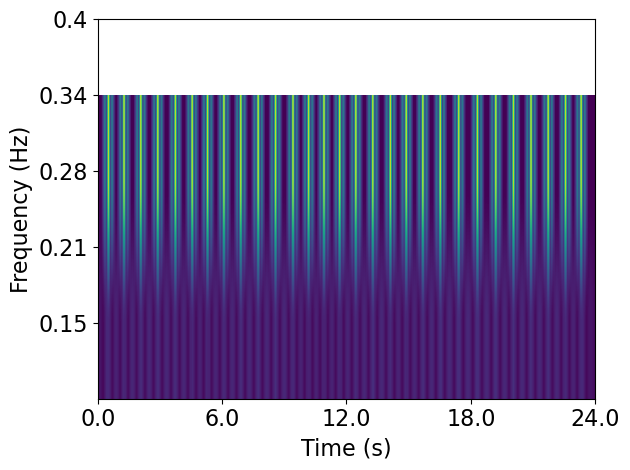

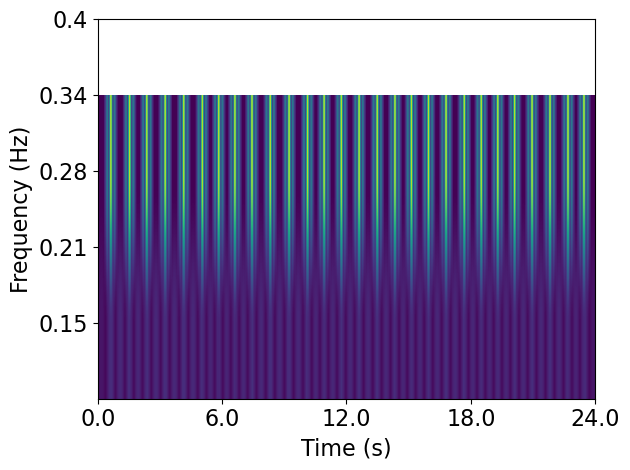

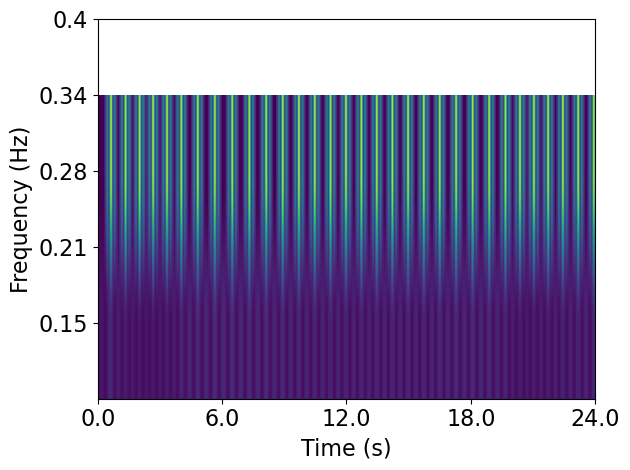

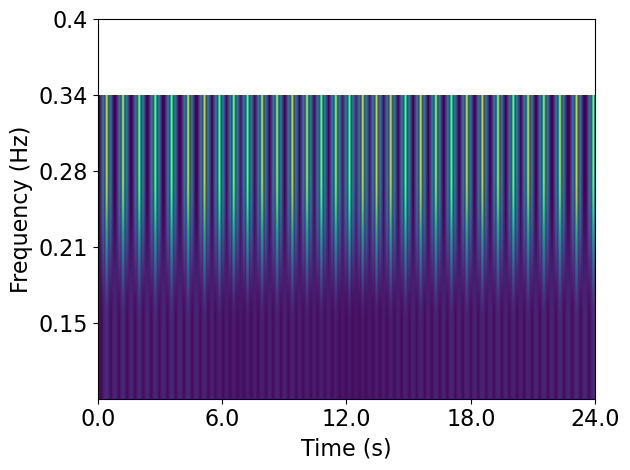

In [109]:
n_seconds = 24
times = create_times(n_seconds, srate)

for b in AUDIO_BLOCKS:
    sig = ecg_raw[0][b][1] #[:6000]
    cleaned = nk.ecg_clean(sig, sampling_rate=srate, method="neurokit")
    peaks, info = nk.ecg_peaks(cleaned, sampling_rate=srate, correct_artifacts=True)
    rri, rri_time = _hrv_get_rri(peaks['ECG_R_Peaks'].values, sampling_rate=srate)
    # Process R-R intervals (interpolated at 100 Hz by default)
    rri, rri_time, sampling_rate = nk.intervals_process(
        rri, intervals_time=rri_time, interpolate=True, interpolation_rate=None,
    )  
    # Settings for the wavelet transform algorithm
    freqs = np.linspace(0.15, 0.4, 2)
    # Compute wavelet transform using compute Morlet wavelet transform algorithm
    mwt = compute_wavelet_transform(rri, fs=srate, n_cycles=0.25, freqs=freqs)
    # Plot morlet wavelet transform
    plot_timefrequency(times, freqs, mwt)
    # Plot a segment of our simulated time series
    #plot_time_series(times, sig, xlim=[0, 24])